In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import DatasetFolder

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.preprocessing import label_binarize

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# Define the transformations
transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(degrees=15),
    # transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.Lambda(lambda x: x.to(torch.float32))
])

root = '../dataset'

# Initialize DatasetFolder for train and validation datasets
train_dataset = DatasetFolder(
    root=os.path.join(root, 'train'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)
test_dataset = DatasetFolder(
    root=os.path.join(root, 'val'),
    loader=lambda x: torch.from_numpy(np.load(x)),
    extensions='npy',
    transform=transform
)

# Split the train dataset to get the validation dataset
train_dataset, val_dataset = random_split(train_dataset, [int(len(train_dataset) * 0.9), int(len(train_dataset) * 0.1)])

# Set the batch size
batch_size = 60

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print some information about the data
print(f'Train dataset size: {len(train_dataset)}')
print(f'Val dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Image shape: {train_dataset[0][0].shape}')
print(f'Classes: {train_dataset.dataset.classes}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 27000
Val dataset size: 3000
Test dataset size: 7500
Image shape: torch.Size([1, 150, 150])
Classes: ['no', 'sphere', 'vort']
Image tensor type: torch.float32
Batches: 450


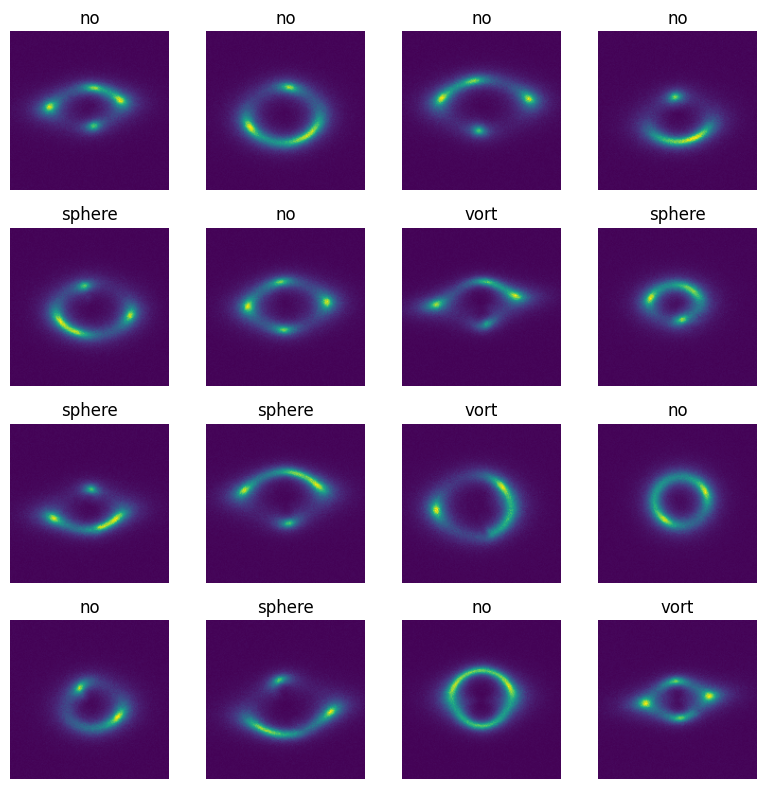

In [3]:
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Visualize some images in the train dataset
fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    if i < 16:
        image, label = images[i], labels[i]

        img = image.numpy().transpose((1, 2, 0))
        img = np.clip(img, 0, 1)

        ax.imshow(img)
        ax.set_title(train_dataset.dataset.classes[label])
        ax.axis('off')
    else:
        break

plt.tight_layout()
plt.show()

In [4]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=20, warmup_epochs=None, save_path='../best_param_ViT.pt'):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    } # Initialize a dictionary to store epoch-wise results
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        # Warm-up period
        if warmup_epochs is not None:
            if epoch < warmup_epochs:
                lr = 1e-13 * (10 ** epoch) 
                for param_group in optimizer.param_groups:
                    param_group['lr'] = lr

        # Training phase
        model.train()
        train_loss = 0.0
        train_corrects = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(F.softmax(outputs, dim=1), 1)
            train_corrects += torch.sum(preds == labels.data).item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data).item()

            val_loss /= len(val_loader.dataset)
            val_acc = val_corrects / len(val_loader.dataset)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # Print results
        print(f"Epoch [{epoch + 1}/{num_epochs}] w/ LR = {optimizer.param_groups[0]['lr']}")
        print(f"\tTrain Loss: {train_loss:.4f}\tTrain Acc: {train_acc:.4f}")
        print(f"\tVal Loss: {val_loss:.4f}\tVal Acc: {val_acc:.4f}")

        # Step the scheduler
        if scheduler is not None:
            scheduler.step(val_loss)

        # Save the parameters with the best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), save_path)

    model.load_state_dict(torch.load(save_path))

    return history, model

In [5]:
def evaluate_model(model, criterion, model_name):
    model.eval()
    y_pred_probs = []
    y_true = []
    total_loss = 0.0
    total_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            total_corrects += torch.sum(preds == labels).item()

            y_pred_probs.extend(outputs.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_loss = total_loss / len(test_loader.dataset)
    test_acc = total_corrects / len(test_loader.dataset)

    # Binarize the labels for ROC AUC
    y_true_binary = label_binarize(y_true, classes=[0, 1, 2])

    # Compute ROC AUC
    roc_auc = roc_auc_score(y_true_binary, y_pred_probs, multi_class='ovr')
    
    print(f'Test Loss: {test_loss:.4f}')
    print(f'Accuracy: {test_acc:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    classes = ['no', 'sphere', 'vort']

    # Plot confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, np.argmax(y_pred_probs, axis=1))
    sns.heatmap(cm, annot=True, fmt='d', cmap='icefire', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Plot ROC curve for each class
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(np.array(y_true_binary).ravel(), np.array(y_pred_probs).ravel())
    plt.plot(fpr, tpr, color='orange', label=f'{model_name}, {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()

In [21]:
# Hyperparameters
EPOCHS = 50
LEARNING_RATE = 1e-4
NUM_CLASSES = 3
PATCH_SIZE = 15
IMG_SIZE = 150
IN_CHANNELS = 1
NUM_HEADS = 5
DROP_OUT = 0.001
HIDDEN_DIM = 225
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = 'gelu'
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2

In [7]:
# Patch embedding
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size),
            nn.Flatten(2)
        )
        self.cls_token = nn.Parameter(torch.randn(1, in_channels, embed_dim), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(1, num_patches + 1, embed_dim), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x
        x = self.dropout(x)

        return x

In [19]:
# ViT class
class ViT(nn.Module):
    def __init__(
        self, num_patches, img_size, num_classes,
        patch_size, embed_dim, num_encoders, num_heads,
        hidden_dim, dropout, activation, in_channels
    ):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            activation=activation,
            batch_first=True,
            norm_first=True
        )
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])

        return x

In [22]:
model = ViT(
    NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE,
    EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM,
    DROP_OUT, ACTIVATION, IN_CHANNELS
).to(device)

model

ViT(
  (embeddings_block): PatchEmbedding(
    (patcher): Sequential(
      (0): Conv2d(1, 225, kernel_size=(15, 15), stride=(15, 15))
      (1): Flatten(start_dim=2, end_dim=-1)
    )
    (dropout): Dropout(p=0.001, inplace=False)
  )
  (encoder_blocks): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=225, out_features=225, bias=True)
        )
        (linear1): Linear(in_features=225, out_features=225, bias=True)
        (dropout): Dropout(p=0.001, inplace=False)
        (linear2): Linear(in_features=225, out_features=225, bias=True)
        (norm1): LayerNorm((225,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((225,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.001, inplace=False)
        (dropout2): Dropout(p=0.001, inplace=False)
      )
    )
  )
  (mlp_head): Sequential(
    (0): LayerNorm((

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=ADAM_BETAS, weight_decay=ADAM_WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

history, model = train_model(model, criterion, optimizer, scheduler, num_epochs=50)
print('Finished')

Epoch [1/50] w/ LR = 0.0001
	Train Loss: 1.1054	Train Acc: 0.3337
	Val Loss: 1.1070	Val Acc: 0.3250
Epoch [2/50] w/ LR = 8.899100254881614e-05
	Train Loss: 1.1017	Train Acc: 0.3330
	Val Loss: 1.1005	Val Acc: 0.3390
Epoch [3/50] w/ LR = 8.905247900877443e-05
	Train Loss: 1.1008	Train Acc: 0.3336
	Val Loss: 1.1004	Val Acc: 0.3360
Epoch [4/50] w/ LR = 8.905338159397784e-05
	Train Loss: 1.1007	Train Acc: 0.3346
	Val Loss: 1.0999	Val Acc: 0.3390
Epoch [5/50] w/ LR = 8.905812494724596e-05
	Train Loss: 1.1026	Train Acc: 0.3308
	Val Loss: 1.0985	Val Acc: 0.3360
Epoch [6/50] w/ LR = 8.907049038716179e-05
	Train Loss: 1.1014	Train Acc: 0.3327
	Val Loss: 1.0992	Val Acc: 0.3360
Epoch [7/50] w/ LR = 8.906393673493952e-05
	Train Loss: 1.1022	Train Acc: 0.3266
	Val Loss: 1.0988	Val Acc: 0.3420
Epoch [8/50] w/ LR = 8.906840198308952e-05
	Train Loss: 1.1013	Train Acc: 0.3343
	Val Loss: 1.1027	Val Acc: 0.3400
Epoch [9/50] w/ LR = 8.903150464456813e-05
	Train Loss: 1.1014	Train Acc: 0.3359
	Val Loss: 1.1

In [ ]:
model.load_state_dict(torch.load('../best_param_ViT.pt'))

In [ ]:
evaluate_model(model, criterion, 'ViTSD')